## 1) 어텐션을 이용한 텍스트 요약 Text Summarization with Attention mechanism
* 텍스트 요약: 상대적으로 큰 원문을 핵심 내용만 간추려서 상대적으로 작은 요약문으로 변환
* 읽는 사람이 시간을 단축해서 내용을 빠르게 이해할 수 있다는 점에서 꼭 필요한 능력
* 그 중 한 가지 방법인 seq2seq 구현
* 그리고 어텐션 메커니즘 적용

### 1. 텍스트 요약 Text Summarization
#### 1) 추출적 요약(Extractive summarization)
* 원문에서 중요한 핵심 문장 또는 단어구를 몇 개 뽑아서 이들로 구성된 요약문을 만드는 방법
* 추출적 요약의 결과로 나온 요약문의 문장이나 단어구들은 전부 원문에 있는 문장들
* 대표적인 알고리즘으로 머신러닝 알고리즘인 TextRank
* 단점: 이미 존재하는 문장이나 단어구로만 구성하므로 모델의 언어 표현 능력이 제한됨
#### 2) 추상적 요약(Abstractive summarization)
* 원문에 없던 문장도 핵심 문맥을 반영한 새로운 문장을 생성해서 원문을 요약하는 방법
* 주로 인공 신경망 사용. 대표적 모델로 seq2seq 있음.
* 단점: seq2seq와 같은 인공 신경망들은 기본적으로 지도 학습. 그러므로 데이터를 구성하는 것 자체가 하나의 부담


### 2. 아마존 리뷰 데이터에 대한 이해


In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
np.random.seed(seed=0)

In [2]:
from google.colab import drive
drive.mount('content/')


Mounted at content/


In [3]:
import csv

#### 1) 데이터 로드

In [5]:
data = pd.read_csv('/content/content/MyDrive/Reviews.csv', nrows=100000, engine='python', encoding='utf-8', error_bad_lines=False, quoting=csv.QUOTE_NONE)
print('전체 리뷰 개수 :',(len(data)))

Streaming output truncated to the last 5000 lines.
Skipping line 53790: Expected 10 fields in line 53790, saw 11
Skipping line 53794: Expected 10 fields in line 53794, saw 11
Skipping line 53795: Expected 10 fields in line 53795, saw 13
Skipping line 53797: Expected 10 fields in line 53797, saw 11
Skipping line 53798: Expected 10 fields in line 53798, saw 18
Skipping line 53799: Expected 10 fields in line 53799, saw 12
Skipping line 53802: Expected 10 fields in line 53802, saw 12
Skipping line 53803: Expected 10 fields in line 53803, saw 11
Skipping line 53805: Expected 10 fields in line 53805, saw 12
Skipping line 53806: Expected 10 fields in line 53806, saw 20
Skipping line 53807: Expected 10 fields in line 53807, saw 35
Skipping line 53808: Expected 10 fields in line 53808, saw 14
Skipping line 53809: Expected 10 fields in line 53809, saw 13
Skipping line 53810: Expected 10 fields in line 53810, saw 12
Skipping line 53811: Expected 10 fields in line 53811, saw 11
Skipping line 53812

전체 리뷰 개수 : 25865


In [6]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"""Product arrived labeled as Jumbo Salted Peanu..."
2,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
3,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
4,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [7]:
# 필요한 열만 저장
data = data[['Text', 'Summary']]
data.head()

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,"""Product arrived labeled as Jumbo Salted Peanu...",Not as Advertised
2,If you are looking for the secret ingredient i...,Cough Medicine
3,Right now I'm mostly just sprouting this so my...,Yay Barley
4,This is a very healthy dog food. Good for thei...,Healthy Dog Food


In [8]:
data.sample(10)

,Text,Summary
6084,I know the fresh one in my supermarket was ver...,Delicious
24358,The best food at an afordable price and Ben lo...,Love Love Love this Product for my Ben
845,Got these luscious wine chocolates to use as p...,Excellent Chocolates
24725,I was very excited to purchase these antlers f...,Not happy.
18914,This product was dried up. These prunes are no...,Prune Rocks (as in stones)
8817,Chews are very enticing to our dog .. he does ...,keeps breath cleaner
15366,Absolutley perfect! After reading one person'...,Perfect!
19047,Found these for a great deal..split the box wi...,What's not to like
17222,My tiny Maltese dog loves these treats and the...,My tiny dog loves Zuke's treats !!!
13679,and then got a refund saying the company does ...,I ordered this and waited and waited


In [9]:
len(data)

25865

### 2) 데이터 정제하기

In [10]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 22785
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 18550


In [11]:
# text열에서 중복인 내용이 있다면 중복 제거
data.drop_duplicates(subset=["Text"], inplace=True)
print("전체 샘플수 :", len(data))

전체 샘플수 : 22785


In [12]:
# null 샘플 있는지 확인
print(data.isnull().sum())

Text       0
Summary    0
dtype: int64


In [13]:
# null 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 22785


In [14]:
# 샘플 내부 전처리
# 단어 정규화와 불용어 제거를 위해서 사전 사용

# 전처리 함수 내 사용
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

In [15]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [53]:
# NLTK의 불용어 저장하고 개수 확인
stop_words = set(stopwords.words('english'))
print('불용어 개수 :', len(stop_words))
print(stop_words)

불용어 개수 : 179
{'same', 'being', 'in', 'll', 'shan', "isn't", 'about', "shouldn't", 'during', 'other', 'on', 'ma', 'while', 'before', 'won', 'not', 'that', "that'll", 'am', 'has', 'did', 'there', 'but', 'didn', 'until', 'most', 'were', 'this', 'those', 'y', 'such', 'again', 'are', 'own', 'against', 'mightn', 'under', 'over', "you'd", 'once', 'very', 'do', 'of', 'doesn', "you're", 'will', 'his', 'wasn', 'who', 'weren', "you've", 'me', 'mustn', 'have', 'don', "mightn't", 'all', "wasn't", 'hers', 'had', 'themselves', "hasn't", 'is', 'itself', 'our', 'does', 'we', 'the', "shan't", 'him', 'then', 'm', 'an', 'so', 'down', 'ourselves', 'hadn', 'ours', 'o', "aren't", "hadn't", 'her', 'and', 'a', 'nor', 'into', 'from', 've', 'out', 'having', 'because', 't', "doesn't", 'she', 'yourselves', 'to', 'yourself', "couldn't", 'too', 'up', 'my', 'needn', "don't", "should've", 'hasn', 'some', 'for', 'isn', 'been', 'after', 'how', 'just', 'himself', 'with', 'your', 'between', 'no', "haven't", 'herself', "ne

In [54]:
# 전처리 함수 설계
def preprocess_sentence(sentence, remove_stopwords = True):
  sentence = sentence.lower() #텍스트 소문자화
  sentence = BeautifulSoup(sentence, "lxml").text # html 태그 제거
  sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 제거
  sentence = re.sub('"', '', sentence) #쌍따옴표 " 제거
  sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
  sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
  sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
  sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

  # 불용어 제거 (Text)
  if remove_stopwords:
      tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
  # 불용어 미제거 (Summary)
  else:
      tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
  return tokens

In [55]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'
print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, 0))

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [56]:
# Text열 전처리
# 전처리 후에는 5개의 전처리 된 샘플 출력
clean_text = []
for s in data['Text']:
  clean_text.append(preprocess_sentence(s))
clean_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'right mostly sprouting cats eat grass love rotate around wheatgrass rye',
 'healthy dog food good digestion also good small puppies dog eats required amount every feeding']

In [57]:
# Summary 열 전처리
clean_summary=[]
for s in data['Summary']:
  clean_summary.append(preprocess_sentence(s, 0))
clean_summary[:5]

['good quality dog food',
 'not as advertised',
 'cough medicine',
 'yay barley',
 'healthy dog food']

In [58]:
data['Text'] = clean_text
data['Summary'] = clean_summary

In [59]:
# 전처리 과정에서 빈 값 생겼나?
data.replace('', np.nan, inplace=True)
print(data.isnull().sum())

Text              0
Summary           0
decoder_input     0
decoder_target    0
dtype: int64


In [60]:
data.dropna(axis = 0, inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 21595


텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 50
텍스트의 평균 길이 : 18.55809215096087
요약의 최소 길이 : 1
요약의 최대 길이 : 8
요약의 평균 길이 : 3.128270432970595


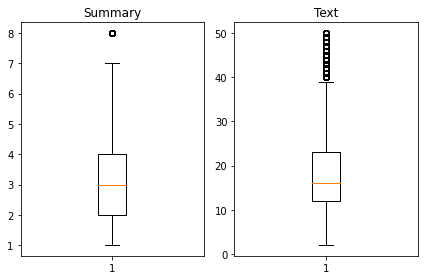

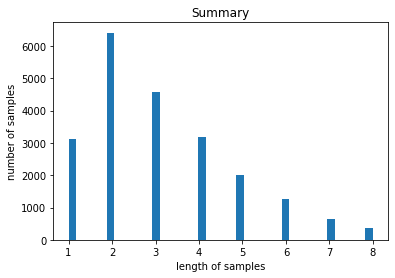

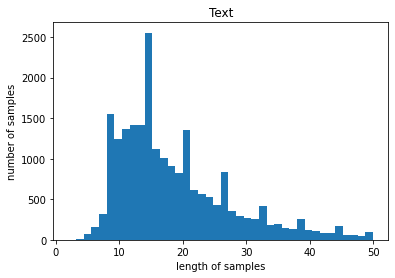

In [61]:
# 길이 분포 출력
text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [62]:
text_max_len = 50
summary_max_len = 8

In [63]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [64]:
below_threshold_len(text_max_len, data['Text'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 1.0


In [65]:
below_threshold_len(summary_max_len, data['Summary'])

전체 샘플 중 길이가 8 이하인 샘플의 비율: 1.0


In [66]:
# 최대 길이보다 큰 샘플들 제거
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 21595


In [67]:
data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised eostoken
2,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
3,right mostly sprouting cats eat grass love rot...,yay barley,sostoken yay barley,yay barley eostoken
4,healthy dog food good digestion also good smal...,healthy dog food,sostoken healthy dog food,healthy dog food eostoken


In [68]:
# seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있음
# 시작 토큰은 sostoken, 종료 토큰은 eostoken이라 명명
# 앞뒤로 추가

data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised eostoken
2,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
3,right mostly sprouting cats eat grass love rot...,yay barley,sostoken yay barley,yay barley eostoken
4,healthy dog food good digestion also good smal...,healthy dog food,sostoken healthy dog food,healthy dog food eostoken


In [69]:
encoder_input = np.array(data['Text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

### 3) 데이터의 분리

In [70]:
# 순서가 섞인 정수 시퀀스들 만들어주기
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[ 5582  2005 16987 ... 13460  4059 10857]


In [71]:
# 이 정수 시퀀스 순서를 데이터의 샘플 순서로 정의해주면 샘플의 순서는 섞이게 됨
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [72]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 4319


In [73]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [74]:
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 17276
훈련 레이블의 개수 : 17276
테스트 데이터의 개수 : 4319
테스트 레이블의 개수 : 4319


#### 4) 정수 인코딩
* 훈련 데이터에 대해서 단어 집합을 만들기

In [75]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

# 단어 집합 생성 동시에 각 단어에 고유한 정수가 부여됨
# 이는 src_tokenizer.word_index에 저장되어 있음
# 빈도수 낮은 단어들은 자연어에서 배제됨

In [76]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) #단어의 수
rare_cnt = 0 #등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다
for key, value in src_tokenizer.word_counts.items():
  total_freq = total_freq + value

  # 단어의 등장 빈도수가 threshold보다 작으면
  if (value < threshold):
    rare_cnt = rare_cnt + 1
    rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 16255
등장 빈도가 6번 이하인 희귀 단어의 수: 12408
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 3847
단어 집합에서 희귀 단어의 비율: 76.33343586588742
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 7.122724108762084


In [77]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words = src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [78]:
print(encoder_input_train[:3])

[[3311, 234, 7, 10, 1, 8, 3106, 882, 2623, 3848, 710, 10, 1656, 146, 882], [12, 363, 134, 65, 89, 220, 28, 520, 1486, 1343, 2624, 1909, 751, 722, 591, 351, 140, 134, 273, 3107, 2188, 449, 817, 112, 5], [76, 186, 14, 2, 752, 13, 30, 55, 122, 326, 1249]]


In [79]:
# 레이블에 해당하는 요약 데이터에 대해서도 수행
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

* 이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었음. 
* 이는 tar_tokenizer.word_index에 저장되어져 있음. 
* 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인

In [80]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 5745
등장 빈도가 5번 이하인 희귀 단어의 수: 4705
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 1040
단어 집합에서 희귀 단어의 비율: 81.89730200174064
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 11.112047177759056


In [81]:
# 등장 빈도로 차지하는 비중이 적은 단어들은 정수 인코딩 과정에서 배제
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [82]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

In [83]:
print(decoder_input_train[:5])

[[1, 162, 688, 10], [1, 1225, 174], [1, 17], [1, 1923, 909, 295], [1, 3, 88]]


In [84]:
print(decoder_target_train[:5])

[[162, 688, 10, 2], [1225, 174, 2], [17, 2], [1923, 909, 295, 2], [3, 88, 2]]


#### 5) 빈 샘플(empty samples) 제거
* 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었다는 것을 의미
* 이러한 샘플들의 인덱스를 받아오기
  * 주의할 점! 요약문인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플수와 동일하여 단어 집합 제한에도 삭제되지 않음
  * 그래서 길이가 0이 된 요약문의 실질적 길이는 1
  * decoder_input에는 sostoken, decoder_target에는 eostoken만 남았을 것이기 때문

In [85]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

* 훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 저장. 이 샘플들을 모두 삭제하고자 함

In [86]:
print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

삭제할 훈련 데이터의 개수 : 463
삭제할 테스트 데이터의 개수 : 151


In [87]:
# 삭제 후 개수

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 16813
훈련 레이블의 개수 : 16813
테스트 데이터의 개수 : 4168
테스트 레이블의 개수 : 4168


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


#### 6) 패딩하기
* 앞서 계산해둔 최대 길이로 맞추어 훈련 데이터와 테스트 데이터에 대해서 패딩 작업 수행

In [88]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

### 3. seq2seq + attention으로 요약 모델 설계 및 훈련 시키기

In [89]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [92]:
# 인코더 설계
# LSTM 층 3개

embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)


In [93]:
# 디코더 설계: 출력층은 제외하고 설계
# 사실상 인코더의 설계와 동일하지만 초기 상태를 인코더의 상태로 주어야 함
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [94]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 50, 128)      1024000     ['input_3[0][0]']                
                                                                                                  
 lstm_2 (LSTM)                  [(None, 50, 256),    394240      ['embedding_2[0][0]']            
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

In [95]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 50, 128)      1024000     ['input_3[0][0]']                
                                                                                                  
 lstm_2 (LSTM)                  [(None, 50, 256),    394240      ['embedding_2[0][0]']            
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

* 3,633,104개의 매개변수를 가진 seq2seq 모델이 설계됨
* 그런데 이번 챕터에서는 어텐션 메커니즘을 사용할 예정이므로 위에서 설계한 출력층을 사용하지 않고, 어텐션 메커니즘이 결합된 새로운 출력층을 설계
* 어텐션 함수 직접 사용 안 하고 깃허브에 공개된 것 사용

In [99]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")

('attention.py', <http.client.HTTPMessage at 0x7fc610a95ad0>)

In [100]:
import tensorflow as tf
import os
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [101]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 50, 128)      1024000     ['input_3[0][0]']                
                                                                                                  
 lstm_2 (LSTM)                  [(None, 50, 256),    394240      ['embedding_2[0][0]']            
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

In [102]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [104]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)

history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 5)

Epoch 1/5
66/66 [==============================] - 284s 4s/step - loss: 2.4607 - val_loss: 2.3082
Epoch 2/5
66/66 [==============================] - 287s 4s/step - loss: 2.3013 - val_loss: 2.2379
Epoch 3/5
66/66 [==============================] - 291s 4s/step - loss: 2.2349 - val_loss: 2.2106
Epoch 4/5
66/66 [==============================] - 293s 4s/step - loss: 2.1832 - val_loss: 2.1767
Epoch 5/5
66/66 [==============================] - 291s 4s/step - loss: 2.1278 - val_loss: 2.1178


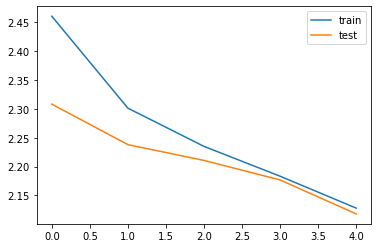

In [105]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 4. seq2seq + attention으로 요약 모델 테스트하기
* 테스트를 위해 필요한 3개의 사전 만들기

In [126]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [127]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

In [128]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [129]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [130]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [131]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [133]:
for i in range(500, 550):
    print("원문 : ",seq2text(encoder_input_test[i]))
    print("실제 요약문 :",seq2summary(decoder_input_test[i]))
    print("예측 요약문 :",decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 :  impressed bars actually bought mistake thought buying ones nuts would buy 
실제 요약문 : protein bars 
예측 요약문 :  not good


원문 :  girls love cut smaller use training definately able keep dogs attention know something yummy tasty coming way price right amount long price remains perfect plan steady supply great product 
실제 요약문 : dogs love these 
예측 요약문 :  great product


원문 :  cannot find cold brewed mint tea local grocery store order amazon year round christmas always give people samples favorite things last christmas gave twinings cold brew mint tea 
실제 요약문 : iced tea so good give it as gift 
예측 요약문 :  great coffee


원문 :  gotten crazy gum years ago used wonder one fellow workers would chew sticks time use three packs day know chew two packs day 
실제 요약문 : the best black licorice gum 
예측 요약문 :  not not


원문 :  goat milk primary source dairy provides good healthy product free additives dry milk pouches convenient environmentally friendly packaging totally paper tin canister resealable l

## 2) 문장 임베딩 기반 텍스트 랭크(TextRank Based on Sentence Embedding)
* 앞서 추상적 요약을 통한 텍스트 요약 수행
* 이번 챕터에서는 텍스트 랭크 알고리즘을 사용하여 또 다른 텍스트 요약 방법인 추출적 요약 진행
### 1. 텍스트 랭크
* 텍스트 랭크 알고리즘의 기반인 페이지 랭크 알고리즘
* 페이지 랭크 알고리즘: 검색 엔진에서 웹 페이지의 순위를 정하기 위해 사용되던 알고리즘
* 아직 미완성인 부분
### 2. 사전 훈련된 임베딩(Pre-trained Embedding)
* 대표적인 워드 임베딩으로는 GloVe, FastText, Word2Vec
* 이들의 사전훈련된 임베딩 사용 방법은 다음과 같음
* 우선 GloVe만 다운로드

In [ ]:
import numpy as np
import gensim
from urllib.request import urlretrieve, urlopen
import gzip
import zipfile

#### 1. 사전 훈련된 GloVe 다운로드 (실습에서 사용)

In [ ]:
urlretrieve("http://nlp.stanford.edu/data/glove.6B.zip", filename="glove.6B.zip")
zf = zipfile.ZipFile('glove.6B.zip')
zf.extractall() 
zf.close()

In [ ]:
glove_dict = dict()
f = open('glove.6B.100d.txt', encoding="utf8") # 100차원의 GloVe 벡터를 사용

for line in f:
  word_vector = line.split()
  word = word_vector[0]
  word_vector_arr = np.asarray(word_vector[1:], dtype='float32') # 100개의 값을 가지는 array로 변환
  glove_dict[word] = word_vector_arr
f.close()

In [ ]:
glove_dict['cat']

#### 2. 사전 훈련된 FastText 다운로드

In [ ]:
!pip install fasttext

In [ ]:
# 300차원의 FastText 벡터 사용
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')
ft = fasttext.load_model('cc.en.300.bin')

In [ ]:
ft.get_word_vector('cat')

#### 3. 사전 훈련된 Word2Vec 다운로드

In [ ]:
# 300차원의 Word2Vec 벡터 사용
urlretrieve("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz", \
                           filename="GoogleNews-vectors-negative300.bin.gz")
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [ ]:
word2vec_model['cat']